In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_csv("HousePricePrediction.xlsx - Sheet1.csv")

# Printing first 5 records of the dataset
dataset.head(5)

,Id,MSSubClass,MSZoning,LotArea,LotConfig,BldgType,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,BsmtFinSF2,TotalBsmtSF,SalePrice
0,0,60,RL,8450,Inside,1Fam,5,2003,2003,VinylSd,0.0,856.0,208500.0
1,1,20,RL,9600,FR2,1Fam,8,1976,1976,MetalSd,0.0,1262.0,181500.0
2,2,60,RL,11250,Inside,1Fam,5,2001,2002,VinylSd,0.0,920.0,223500.0
3,3,70,RL,9550,Corner,1Fam,5,1915,1970,Wd Sdng,0.0,756.0,140000.0
4,4,60,RL,14260,FR2,1Fam,5,2000,2000,VinylSd,0.0,1145.0,250000.0


In [2]:
obj = (dataset.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:", len(object_cols))

int_ = (dataset.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:", len(num_cols))

fl = (dataset.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:", len(fl_cols))

Categorical variables: 4
Integer variables: 0
Float variables: 3


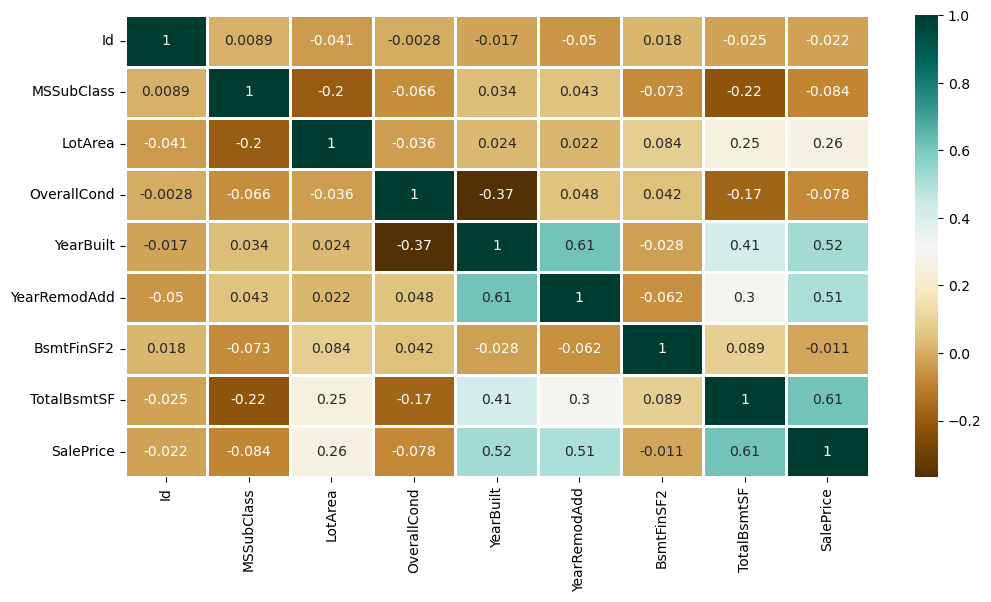

In [3]:
plt.figure(figsize=(12, 6))
categorical_cols = dataset.select_dtypes(include=['object']).columns
corr_matrix = dataset.drop(columns=categorical_cols).corr()

sns.heatmap(corr_matrix, cmap='BrBG', linewidths=2, annot=True)
plt.show()


<Axes: title={'center': 'No. Unique values of Categorical Features'}>

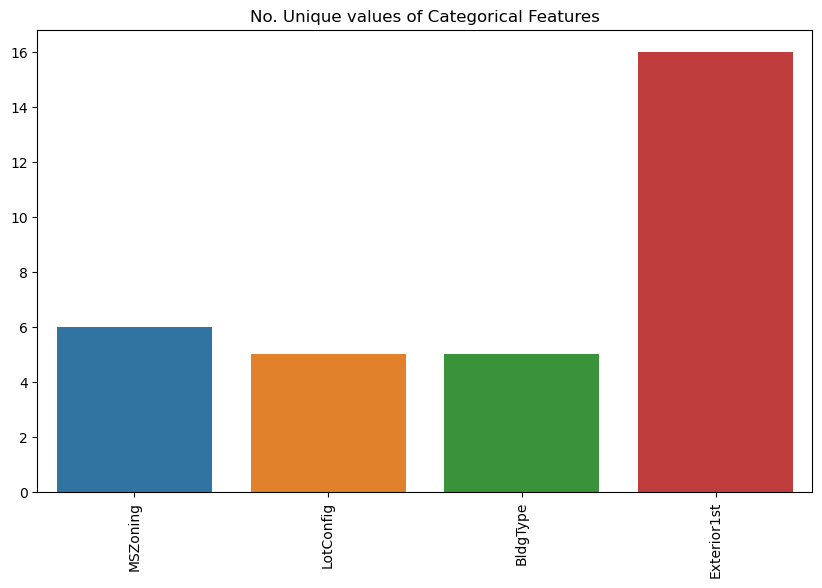

In [4]:
unique_values = []
for col in object_cols:
  unique_values.append(dataset[col].unique().size)

plt.figure(figsize=(10, 6))
plt.title('No. Unique values of Categorical Features')
plt.xticks(rotation=90)
sns.barplot(x=object_cols, y=unique_values)

C:\Users\BISWAJIT\AppData\Local\Temp\ipykernel_9532\2280538051.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(11, 4, index)


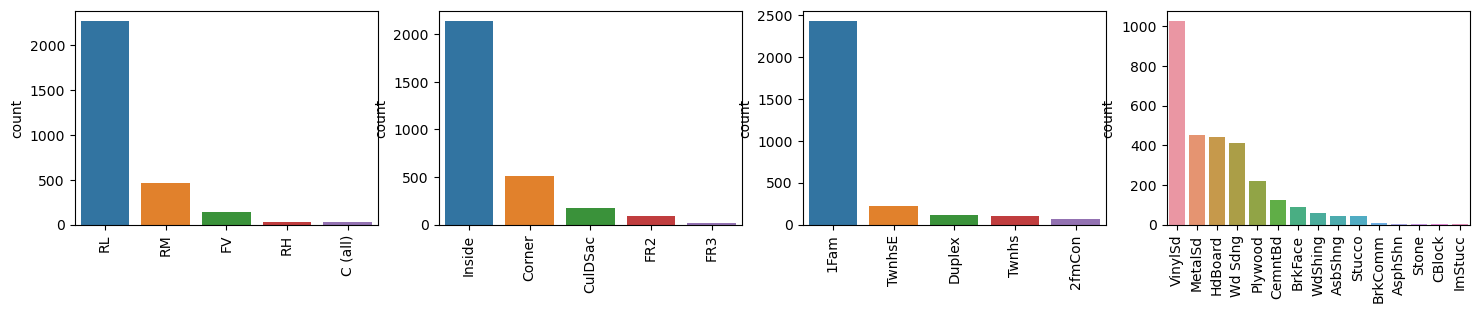

In [5]:
plt.figure(figsize=(18, 36))
plt.title('Categorical Features: Distribution')
plt.xticks(rotation=90)
index = 1

for col in object_cols:
    y = dataset[col].value_counts()
    plt.subplot(11, 4, index)
    plt.xticks(rotation=90)
    sns.barplot(x=list(y.index), y=y)
    index += 1

#### Data Cleaning

In [6]:
dataset.drop(['Id'], axis=1, inplace=True)

In [7]:
dataset['SalePrice'] = dataset['SalePrice'].fillna(dataset['SalePrice'].mean())
new_dataset = dataset.dropna()

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Identify categorical columns
s = (new_dataset.dtypes == 'object')
object_cols = list(s[s].index)

# Create a ColumnTransformer with OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), object_cols)
    ],
    remainder='passthrough'
)

# Apply the ColumnTransformer to the dataset
OH_cols = pd.DataFrame(preprocessor.fit_transform(new_dataset))
OH_cols.index = new_dataset.index

# Get the column names after one-hot encoding
new_columns = list(preprocessor.get_feature_names_out())
OH_cols.columns = new_columns

# Concatenate the one-hot encoded columns to the dataset
df_final = pd.concat([new_dataset.drop(object_cols, axis=1), OH_cols], axis=1)


#### Splitting dataset into training and testing

In [9]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

X = df_final.drop(['SalePrice'], axis=1)
Y = df_final['SalePrice']

X_train, X_valid, Y_train, Y_valid = train_test_split(
    X, Y, train_size=0.8, test_size=0.2, random_state=0)

### SVM

In [10]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_percentage_error

model_SVR = svm.SVR()
model_SVR.fit(X_train, Y_train)
Y_pred_SVR = model_SVR.predict(X_valid)

print(mean_absolute_percentage_error(Y_valid, Y_pred_SVR))

0.18663839696712342


#### Random Forest Regression

In [11]:
from sklearn.ensemble import RandomForestRegressor

model_RFR = RandomForestRegressor(n_estimators=10)
model_RFR.fit(X_train, Y_train)
Y_pred_RFR = model_RFR.predict(X_valid)

mean_absolute_percentage_error(Y_valid, Y_pred_RFR)

0.0012287262010199362

#### Linear Regression

In [12]:
from sklearn.linear_model import LinearRegression

model_LR = LinearRegression()
model_LR.fit(X_train, Y_train)
Y_pred_LR = model_LR.predict(X_valid)

print(mean_absolute_percentage_error(Y_valid, Y_pred_LR))

3.144225246551455e-16


#### Catboost

In [13]:
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score  # Add this import

cb_model = CatBoostRegressor()
cb_model.fit(X_train, Y_train)
preds = cb_model.predict(X_valid)

cb_r2_score = r2_score(Y_valid, preds)

Learning rate set to 0.046797
0:	learn: 55115.8150964	total: 167ms	remaining: 2m 47s
1:	learn: 53150.1568654	total: 186ms	remaining: 1m 32s
2:	learn: 51242.6606204	total: 191ms	remaining: 1m 3s
3:	learn: 49392.3451246	total: 196ms	remaining: 48.8s
4:	learn: 47542.0673315	total: 200ms	remaining: 39.9s
5:	learn: 45771.6502553	total: 207ms	remaining: 34.4s
6:	learn: 44132.4126053	total: 212ms	remaining: 30.1s
7:	learn: 42673.2797370	total: 219ms	remaining: 27.1s
8:	learn: 41118.9227959	total: 224ms	remaining: 24.7s
9:	learn: 39672.8764416	total: 230ms	remaining: 22.7s
10:	learn: 38185.8004067	total: 236ms	remaining: 21.2s
11:	learn: 36797.8179914	total: 241ms	remaining: 19.9s
12:	learn: 35534.6442153	total: 246ms	remaining: 18.7s
13:	learn: 34253.9843060	total: 253ms	remaining: 17.8s
14:	learn: 33137.6119640	total: 258ms	remaining: 16.9s
15:	learn: 32008.8046490	total: 263ms	remaining: 16.2s
16:	learn: 30784.3880650	total: 269ms	remaining: 15.6s
17:	learn: 29777.5257862	total: 274ms	remai

161:	learn: 2201.4557824	total: 994ms	remaining: 5.14s
162:	learn: 2180.1389624	total: 1s	remaining: 5.13s
163:	learn: 2165.6940071	total: 1s	remaining: 5.12s
164:	learn: 2159.3581928	total: 1.01s	remaining: 5.11s
165:	learn: 2140.9991461	total: 1.01s	remaining: 5.1s
166:	learn: 2122.9613930	total: 1.02s	remaining: 5.1s
167:	learn: 2112.5330903	total: 1.03s	remaining: 5.1s
168:	learn: 2099.3926748	total: 1.03s	remaining: 5.09s
169:	learn: 2083.4976692	total: 1.04s	remaining: 5.09s
170:	learn: 2068.3404431	total: 1.05s	remaining: 5.07s
171:	learn: 2061.6681769	total: 1.05s	remaining: 5.08s
172:	learn: 2052.2041902	total: 1.06s	remaining: 5.06s
173:	learn: 2035.1070731	total: 1.06s	remaining: 5.05s
174:	learn: 2020.8677098	total: 1.07s	remaining: 5.06s
175:	learn: 2009.4439267	total: 1.08s	remaining: 5.05s
176:	learn: 1999.5213060	total: 1.09s	remaining: 5.05s
177:	learn: 1991.5945008	total: 1.09s	remaining: 5.04s
178:	learn: 1982.1808419	total: 1.1s	remaining: 5.03s
179:	learn: 1968.670

341:	learn: 1128.6754656	total: 1.99s	remaining: 3.83s
342:	learn: 1125.7921970	total: 2s	remaining: 3.82s
343:	learn: 1123.0575478	total: 2s	remaining: 3.81s
344:	learn: 1120.3569694	total: 2s	remaining: 3.81s
345:	learn: 1117.7148675	total: 2.01s	remaining: 3.8s
346:	learn: 1115.6754053	total: 2.02s	remaining: 3.79s
347:	learn: 1115.3692742	total: 2.02s	remaining: 3.79s
348:	learn: 1112.2870323	total: 2.02s	remaining: 3.78s
349:	learn: 1109.3850469	total: 2.03s	remaining: 3.77s
350:	learn: 1106.6004953	total: 2.04s	remaining: 3.77s
351:	learn: 1104.7870991	total: 2.04s	remaining: 3.76s
352:	learn: 1104.5399108	total: 2.04s	remaining: 3.75s
353:	learn: 1101.2531403	total: 2.05s	remaining: 3.74s
354:	learn: 1098.1985235	total: 2.06s	remaining: 3.73s
355:	learn: 1095.4151465	total: 2.06s	remaining: 3.73s
356:	learn: 1093.9422848	total: 2.06s	remaining: 3.72s
357:	learn: 1091.6102625	total: 2.07s	remaining: 3.71s
358:	learn: 1089.2341975	total: 2.07s	remaining: 3.7s
359:	learn: 1085.4079

506:	learn: 802.8654571	total: 2.78s	remaining: 2.7s
507:	learn: 802.1480910	total: 2.78s	remaining: 2.7s
508:	learn: 800.7518881	total: 2.79s	remaining: 2.69s
509:	learn: 799.3216817	total: 2.79s	remaining: 2.69s
510:	learn: 798.6237893	total: 2.8s	remaining: 2.68s
511:	learn: 796.5357853	total: 2.81s	remaining: 2.67s
512:	learn: 795.2507769	total: 2.81s	remaining: 2.67s
513:	learn: 793.5555171	total: 2.82s	remaining: 2.66s
514:	learn: 792.5751207	total: 2.82s	remaining: 2.65s
515:	learn: 792.2956923	total: 2.83s	remaining: 2.65s
516:	learn: 790.3327256	total: 2.83s	remaining: 2.64s
517:	learn: 789.9504957	total: 2.83s	remaining: 2.64s
518:	learn: 788.5332785	total: 2.84s	remaining: 2.63s
519:	learn: 787.8509414	total: 2.84s	remaining: 2.62s
520:	learn: 786.1720301	total: 2.85s	remaining: 2.62s
521:	learn: 784.6624182	total: 2.85s	remaining: 2.61s
522:	learn: 783.5825685	total: 2.86s	remaining: 2.61s
523:	learn: 782.6746673	total: 2.86s	remaining: 2.6s
524:	learn: 781.4706566	total: 2

698:	learn: 633.7766166	total: 3.78s	remaining: 1.63s
699:	learn: 633.2036459	total: 3.79s	remaining: 1.62s
700:	learn: 632.4929110	total: 3.79s	remaining: 1.62s
701:	learn: 631.4072723	total: 3.79s	remaining: 1.61s
702:	learn: 630.5356255	total: 3.8s	remaining: 1.6s
703:	learn: 630.2320540	total: 3.81s	remaining: 1.6s
704:	learn: 629.3675003	total: 3.81s	remaining: 1.59s
705:	learn: 628.3327180	total: 3.82s	remaining: 1.59s
706:	learn: 627.9783354	total: 3.82s	remaining: 1.58s
707:	learn: 627.1681288	total: 3.83s	remaining: 1.58s
708:	learn: 627.1295259	total: 3.83s	remaining: 1.57s
709:	learn: 626.6050542	total: 3.84s	remaining: 1.57s
710:	learn: 625.8662157	total: 3.84s	remaining: 1.56s
711:	learn: 625.2098076	total: 3.85s	remaining: 1.56s
712:	learn: 624.1974427	total: 3.85s	remaining: 1.55s
713:	learn: 623.7605407	total: 3.86s	remaining: 1.54s
714:	learn: 623.5907828	total: 3.86s	remaining: 1.54s
715:	learn: 622.6353542	total: 3.87s	remaining: 1.53s
716:	learn: 621.7723956	total: 

861:	learn: 545.3901726	total: 4.58s	remaining: 733ms
862:	learn: 544.7718272	total: 4.58s	remaining: 727ms
863:	learn: 544.0423052	total: 4.58s	remaining: 722ms
864:	learn: 543.7686118	total: 4.59s	remaining: 717ms
865:	learn: 543.0980233	total: 4.6s	remaining: 711ms
866:	learn: 542.7020844	total: 4.6s	remaining: 706ms
867:	learn: 542.2095433	total: 4.62s	remaining: 703ms
868:	learn: 541.6807824	total: 4.63s	remaining: 698ms
869:	learn: 541.5035366	total: 4.63s	remaining: 692ms
870:	learn: 541.1053889	total: 4.64s	remaining: 687ms
871:	learn: 540.4263934	total: 4.64s	remaining: 681ms
872:	learn: 539.8249434	total: 4.65s	remaining: 676ms
873:	learn: 539.0918481	total: 4.65s	remaining: 670ms
874:	learn: 538.3137907	total: 4.66s	remaining: 665ms
875:	learn: 537.7115012	total: 4.66s	remaining: 660ms
876:	learn: 537.4344782	total: 4.66s	remaining: 654ms
877:	learn: 536.7880068	total: 4.67s	remaining: 649ms
878:	learn: 536.4284848	total: 4.67s	remaining: 644ms
879:	learn: 536.1555173	total:

0.9978299696966695

In [14]:
print(cb_r2_score)

0.9978299696966695
